In [1]:
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/"
os.chdir(running_path)

In [2]:
import xarray as xr
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
#import xrft
import matplotlib.pyplot as plt
#import pandas as pd
from tqdm import tqdm
import os
import glob
from pathlib import Path
from typing import Union, List
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch.nn.functional as F
import cartopy.crs as ccrs
import pickle
import time

In [5]:
from src.utils import *


In [6]:

sound_speed_path = "/Odyssey/public/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"


# ECS check

In [ ]:

tst_mike_z_w = np.array([0., 100., 200., 300., 400., 500., 600., 
                                700., 800., 900., 1000., 1100., 1300., 
                                1400., 1500., 1600., 1700., 1800., 1900., 
                                2000., 2100., 2200., 2300., 2400., 2500., 
                                2600., 3000.])
tst_mike_sos_w = np.array([1536.8, 1538.5, 1530.2, 1523.4, 1517.7, 
                                    1513.1, 1509.4, 1506.5, 1504.2, 1502.5, 
                                    1501.3, 1500.50, 1500.1, 1500.0, 
                                    1500.1, 1500.4, 1501.0, 1501.7, 1502.5, 
                                    1503.5, 1504.6, 1505.7, 1507.0, 1508.3, 
                                    1509.6, 1511.0, 1512.5])
# NOVEMBER profile
tst_nov_z_w = np.array([0., 4.1, 8.2, 13.0, 18.4, 24.7, 32.0, 
                                40.3, 49.9, 60.9, 73.55, 88.1, 104.8, 
                                124.0, 145.0, 166.1, 187.1, 208.1, 229.1, 
                                250.1, 271.1, 292.1, 329.7, 361.7, 398.6, 
                                535.8, 623.0, 887.4, 887.4, 887.4, 887.4, 
                                887.4, 887.4])
tst_nov_sos_w = np.array([1513.4246, 1513.0774, 1513.157, 
                                1513.2363, 1513.323,  1513.4213, 
                                1513.5321, 1513.6555, 1513.7941, 
                                1513.8442, 1513.646, 1513.7023, 
                                1511.871, 1510.4368, 1509.9404, 
                                1510.0405, 1509.4906, 1509.3845, 
                                1509.4773, 1509.7028, 1509.9937, 
                                1510.3146, 1510.911, 
                                1511.3512, 1511.7878, 1513.807, 
                                1514.7437, 1518.7205, np.nan, np.nan, np.nan, 
                                np.nan, np.nan])

typical_profiles = dict(mike= (tst_mike_z_w, tst_mike_sos_w), 
                        november= (tst_nov_z_w, tst_nov_sos_w))

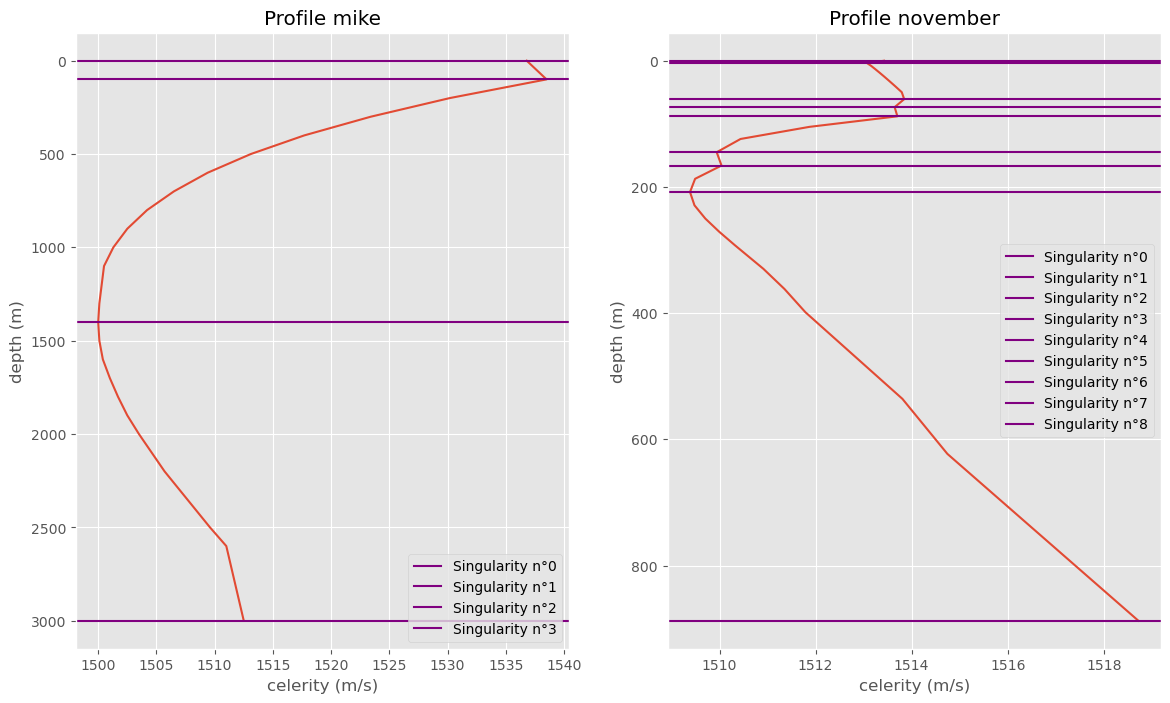

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (14, 8))
style = ['-', '--', '-.', ':']
for i, items in enumerate(typical_profiles.items()):
    ax = axs[i]
    name, profiles = items 
    z, c = profiles
    
    ax.plot(c, z)
    
    for j, singularity in enumerate(reduce_profile(z, c)[0]):   ##? use get_ecs
        ax.axhline(y=singularity, label=f'Singularity n°{j}', c='purple')
    
    ax.invert_yaxis()
    ax.set_xlabel('celerity (m/s)')
    ax.set_ylabel('depth (m)')
    ax.set_title(f"Profile {name}")
    ax.legend()

# for i, ax in enumerate(axs.flatten()):
#     ax.plot

# normalization

In [2]:
from src.utils import *
import hydra
import src.differentiable_fonc as DF
from sklearn.decomposition import PCA


In [3]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [4]:


cfg_path = "config/xp/autoencoder_V2.yaml"
cfg = OmegaConf.load(cfg_path)
display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))


```yaml

datamodule:
  _target_: src.autoencoder_datamodule.AutoEncoderDatamodule_${dimensions}
  depth_pre_treatment: {method: none, params: 1}
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 2}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssp_da, ssf_da_path: '${paths.sound}'}
  manage_nan: suppress
  n_profiles: null
  norm_stats: {method: mean_std, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dim: '${dimensions}', dm: '${datamodule}', lit_mod: '${model}',
  trainer: '${trainer}'}
hydra:
  job:
    env_set: {CUDA_VISIBLE_DEVICES: 1}
  run: {dir: '${trainer.logger.save_dir}/${trainer.logger.name}/${trainer.logger.version}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  dim: ${dimensions}
  loss_weight: {ecs_weight: 0, fft_weight: 0, gradient_weight: 0, min_max_position_weight: 0,
    min_max_value_weight: 0, max_position_weight: 0, max_value_weight: 0, prediction_weight: 0.5,
    weighted_weight: 1}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.utils.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.001}
model_architecture: AE_CNN
model_config:
  accumulate_grad_batches: {1D: 1, 2D: 1, 3D: 1}
  batch_size: {1D: 512, 2D: 32, 3D: 4}
  model_hparams:
    AE_CNN_1D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 9
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_2D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_3D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
  save_dir: {AE_CNN: 'pooling_${model.model_hparams.pooling}_on_dim_${model.model_hparams.pooling_dim}/channels_${model.model_hparams.channels_list}/upsample_mode_${model.model_hparams.upsample_mode}/linear_later_${model.model_hparams.linear_layer}_lattent_size_${model.model_hparams.latent_size}/${model.model_hparams.n_conv_per_layer}_conv_per_layer/padding_${model.model_hparams.padding}/interp_size_${model.model_hparams.interp_size}/final_upsample_${model.model_hparams.final_upsample_str}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}',
    AE_CNN_pool_1D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}',
    AE_CNN_pool_2D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}_normalization_${datamodule.norm_stats.method}'}
normalization:
  mean_std: {mean: null, std: null}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: null, x_min: null}
paths: {sound: /Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc}
patience: 5
root_save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs"
save_dir_name: test
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, min_delta: 1.0e-06, monitor: val_loss,
    patience: '${trainer.max_epochs}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: true,
    name: '${save_dir_name}', save_dir: '${root_save_dir}/AE/${model.model_name}',
    version: 'pred_${model.loss_weight.prediction_weight}_grad_${model.loss_weight.gradient_weight}_max_pos_${model.loss_weight.max_position_weight}_max_value_${model.loss_weight.max_value_weight}_fft_${model.loss_weight.fft_weight}_weighted_${model.loss_weight.weighted_weight}_inflection_pos_${model.loss_weight.min_max_position_weight}_inflection_value_${model.loss_weight.min_max_value_weight}/depth_pre_treatment_${datamodule.depth_pre_treatment.method}_n_components_${datamodule.depth_pre_treatment.params}/${model_config.save_dir.${model_architecture}}/lr_${model.opt_fn.lr}/normalization_${datamodule.norm_stats.method}/manage_nan_${datamodule.manage_nan}/n_profiles_${datamodule.n_profiles}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 1


```

In [5]:
dm_dict = cfg.datamodule
dm = hydra.utils.call(dm_dict) #hydra.utils.call(dm_dict)
train_ssp_tens, test_ssp_tens, dm, coords = loading_datamodule(dm)

In [6]:
train_ssp_tens

tensor([[[[ 1.8580,  1.8451,  1.8183,  ...,  1.8940,  1.8943,  1.8947],
          [ 1.8556,  1.8390,  1.8072,  ...,  1.8963,  1.8948,  1.8944],
          [ 1.8488,  1.8290,  1.7936,  ...,  1.9055,  1.9020,  1.9000],
          ...,
          [ 0.3748,  0.6066,  0.7447,  ...,  1.4501,  1.4587,  1.4687],
          [ 0.6023,  0.7393,  0.7634,  ...,  1.4293,  1.4462,  1.4566],
          [ 0.7200,  0.7976,  0.7899,  ...,  1.3860,  1.4212,  1.4435]],

         [[ 1.8595,  1.8466,  1.8197,  ...,  1.8571,  1.8577,  1.8584],
          [ 1.8571,  1.8405,  1.8087,  ...,  1.8592,  1.8579,  1.8579],
          [ 1.8503,  1.8304,  1.7950,  ...,  1.8687,  1.8653,  1.8636],
          ...,
          [ 0.3631,  0.5974,  0.7351,  ...,  1.4423,  1.4511,  1.4613],
          [ 0.5931,  0.7299,  0.7534,  ...,  1.4211,  1.4383,  1.4490],
          [ 0.7109,  0.7882,  0.7802,  ...,  1.3770,  1.4128,  1.4356]],

         [[ 1.8611,  1.8482,  1.8214,  ...,  1.8376,  1.8380,  1.8386],
          [ 1.8587,  1.8421,  

In [7]:
train_data_array = train_ssp_tens.detach().cpu().numpy()

In [8]:
train_shape = train_data_array.shape
train_shape

(255, 107, 174, 240)

In [19]:
n_components = 107
pca = PCA(n_components = n_components, svd_solver = 'auto')


In [20]:
train_data_array.mean()

4.944352e-07

In [21]:
unorm_ssp_arr_3D(train_data_array,dm).mean()

1517.3341

In [22]:
reduced_train_data = pca.fit_transform(train_data_array.transpose(0,2,3,1).reshape(-1,train_shape[1]))
reduced_train_data.shape

(10648800, 107)

[7.8829962e-01 1.6882208e-01 2.6966847e-02 1.1771280e-02 1.8308437e-03
 1.0517240e-03 4.8551211e-04 2.5516591e-04 1.7276063e-04 1.0252334e-04
 6.7861089e-05 4.3065764e-05 3.0251898e-05 2.0006499e-05 1.5691043e-05
 1.1917242e-05 9.0095500e-06 7.3286692e-06 5.5841374e-06 4.3571149e-06
 3.4601085e-06 2.6414273e-06 2.1061667e-06 1.6897694e-06 1.4252149e-06
 1.1255726e-06 1.1015834e-06 9.6215695e-07 8.9591362e-07 7.6896305e-07
 6.9361352e-07 6.6987690e-07 5.8550307e-07 5.5069427e-07 5.3322071e-07
 5.2012030e-07 4.6503902e-07 4.4452446e-07 3.9386720e-07 3.8203828e-07
 3.5680051e-07 3.5082721e-07 3.0820217e-07 3.0513581e-07 2.8746678e-07
 2.8160389e-07 2.5767997e-07 2.4813573e-07 2.4141031e-07 2.2446760e-07
 2.0924068e-07 2.0174458e-07 1.9241598e-07 1.9031972e-07 1.7780083e-07
 1.6763478e-07 1.4752557e-07 1.4254911e-07 1.3017656e-07 1.2793500e-07
 1.1550444e-07 9.1984006e-08 8.7780400e-08 8.1452875e-08 7.0201615e-08
 6.2202311e-08 4.7153520e-08 4.5609895e-08 3.7430748e-08 1.3582252e-08
 8.986

Text(0.5, 1.0, 'Explained variance ratio norm SSP')

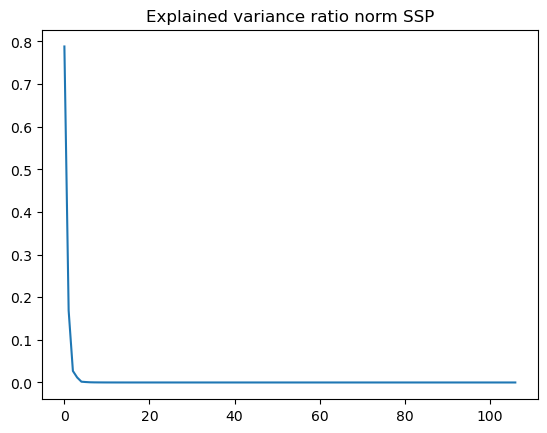

In [23]:
import matplotlib.pyplot as plt
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio norm SSP")


In [14]:
reduced_min = reduced_train_data.min()
print(reduced_min)
reduced_max = reduced_train_data.max()
print(reduced_max)
reduced_mean = reduced_train_data.mean()
print(reduced_mean)
reduced_mean_along_depth = reduced_train_data.mean(axis=1)
print(reduced_mean_along_depth)
reduced_std = reduced_train_data.std()
print(reduced_std)
reduced_std = reduced_train_data.std(axis=1)
print(reduced_std)

-301.17285
2269.4648
18.281307
[19.321836 19.327354 19.3197   ... 16.676044 16.67324  16.67196 ]
206.22414
[213.17503 213.09619 212.95386 ... 187.24426 187.24773 187.24275]


In [15]:
n_components = 5
pca = PCA(n_components = n_components, svd_solver = 'auto')

reduced_train_data = pca.fit_transform(train_data_array.transpose(0,2,3,1).reshape(-1,train_shape[1]))

reduced_min = reduced_train_data.min()
print("min: ",reduced_min)
reduced_max = reduced_train_data.max()
print("max: ",reduced_max)
reduced_mean = reduced_train_data.mean()
print("mean: ",reduced_mean)
reduced_mean_along_depth = reduced_train_data.mean(axis=1)
print("mean along components: ",reduced_mean_along_depth)
reduced_std = reduced_train_data.std()
print("std: ", reduced_std)
reduced_std = reduced_train_data.std(axis=1)
print("std along components: ",reduced_std)

min:  -23.78277
max:  10.190409
mean:  0.002023181
mean along components:  [ 1.9605567  1.939564   1.8925282 ... -3.3227894 -3.3210187 -3.317471 ]
std:  3.2766194
std along components:  [2.3628323 2.3453662 2.3054633 ... 6.0139074 6.014493  6.0190163]


In [18]:
pca.explained_variance_ratio_

array([0.7882996 , 0.16882208, 0.02696685, 0.01177128, 0.00183084],
      dtype=float32)

min max normalization

In [16]:
min_max_data = (reduced_train_data - reduced_min)/(reduced_max - reduced_min) 

print(min_max_data.min(),min_max_data.max(),min_max_data.mean(),min_max_data.std())

0.0 1.0 0.70010734 0.09644721


In [17]:
output_train_da.data = pca.inverse_transform(min_max_data).reshape(train_shape[0],train_shape[2],train_shape[3],train_shape[1]).transpose(0,3,1,2)


NameError: name 'output_train_da' is not defined

In [ ]:
x = torch.tensor(output_train_da.data)
dif_pca_4D = DF.Differentiable4dPCA(pca)
x = dif_pca_4D.transform(x)

print(x.min(),x.max(),x.mean(),x.std())

tensor(-4.0026e-05, dtype=torch.float64) tensor(1.0000, dtype=torch.float64) tensor(0.3001, dtype=torch.float64) tensor(0.0209, dtype=torch.float64)


: 

mean std

In [ ]:
mean_std_data = (reduced_train_data - reduced_mean)/(reduced_std) 

print(mean_std_data.min(),mean_std_data.max(),mean_std_data.mean(),mean_std_data.std())

-14.364867967173682 33.50879849498497 1.5271775453326271e-18 1.000000000000005


mean along depth std

In [ ]:
reduced_mean_along_depth =  (reduced_train_data - reduced_mean_along_depth.reshape(-1,1))/(reduced_std) 
print(reduced_mean_along_depth.min(),reduced_mean_along_depth.max(),reduced_mean_along_depth.mean(),reduced_mean_along_depth.std())

-14.369331593404281 32.996504758425274 -2.654039455979232e-18 0.9953161335010359


<xarray.DataArray 'celerity' (time: 255, z: 107, lat: 174, lon: 240)>
array([[[[1527.36781518, 1527.36743567, 1527.36664577, ...,
          1527.36887413, 1527.36888315, 1527.3688965 ],
         [1527.36774456, 1527.36725629, 1527.36631907, ...,
          1527.36894254, 1527.36889794, 1527.3688873 ],
         [1527.36754422, 1527.36696011, 1527.36591857, ...,
          1527.36921288, 1527.36911064, 1527.36905265],
         ...,
         [1527.32414316, 1527.33096682, 1527.33503356, ...,
          1527.35580309, 1527.35605744, 1527.35635254],
         [1527.33083973, 1527.33487362, 1527.33558509, ...,
          1527.35519259, 1527.35568992, 1527.35599467],
         [1527.33430594, 1527.33659123, 1527.33636594, ...,
          1527.35391578, 1527.35495425, 1527.35561042]],

        [[1527.55001878, 1527.54963928, 1527.54884937, ...,
          1527.54994799, 1527.54996547, 1527.54998827],
         [1527.54994817, 1527.54945991, 1527.54852266, ...,
          1527.55001234, 1527.54997371, 1527.54997332],
         [1527.54974783, 1527.54916372, 1527.54812211, ...,
          1527.55029052, 1527.55019139, 1527.55014134],
...
         [1495.15885799, 1495.15889094, 1495.15878797, ...,
          1495.16011115, 1495.16012816, 1495.16014127],
         [1495.15881013, 1495.15881972, 1495.15873407, ...,
          1495.15998802, 1495.16000111, 1495.16000942],
         [1495.15866174, 1495.1587155 , 1495.15869117, ...,
          1495.15996988, 1495.15997468, 1495.15995869]],

        [[1494.09924939, 1494.09903146, 1494.09869583, ...,
          1494.09437166, 1494.09431561, 1494.09435061],
         [1494.09890539, 1494.09868542, 1494.09838695, ...,
          1494.09400967, 1494.0940704 , 1494.09417898],
         [1494.09851469, 1494.09831642, 1494.098064  , ...,
          1494.0938645 , 1494.09397583, 1494.09413855],
         ...,
         [1494.07540621, 1494.07543241, 1494.07531621, ...,
          1494.07656933, 1494.07658628, 1494.07659865],
         [1494.07533998, 1494.07534977, 1494.07525803, ...,
          1494.07645148, 1494.07646038, 1494.07646893],
         [1494.07523117, 1494.07526211, 1494.07521346, ...,
          1494.0764308 , 1494.07643854, 1494.07642232]]]])
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.6 32.65 32.7 32.75 32.8 ... 41.2 41.25 41.3 41.35
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-08-22T12:00:00 ... 2010-04-06T12:00:00